# Extend profile data by tag_to_cluster mapping

## Ceate a dict: {tag: cluster}

In [3]:
import json
import os

base_dir = os.path.abspath("..")
input_path = os.path.join(base_dir, "data", "tag_clustering", "tags_clustered.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "tag_to_cluster_mapping.json")

# Load file with clusters
with open(input_path, "r", encoding="utf-8") as f:
    clustered = json.load(f)

# Invert to {tag: cluster}
tag_to_cluster = {}
for cluster, tags in clustered.items():
    for tag in tags:
        tag_to_cluster[tag] = cluster

# Save file with mapping
with open(output_path, "w", encoding="utf-8") as out:
    json.dump(tag_to_cluster, out, indent=2)

print(f"Saved tag-to-cluster mapping to: {output_path}")
print(f"Total tags mapped: {len(tag_to_cluster)}")


Saved tag-to-cluster mapping to: C:\Users\nastya\thesis\tum-thesis\data\bipartite_network\tag_to_cluster_mapping.json
Total tags mapped: 2965


## Extend profiles file by adding "tag_clusters":
        "tags": [
            "Lung disease",
            "Oxygen Therapy",
            "Respiratory failure"
        ],
        "tags_clusters" [
            "Respiratory desease", 
            "Respiratory desease", 
            "Respiratory desease"
        ],

### general_profiles_data.json

In [1]:
import json
import os

base_dir = os.path.abspath("..")
general_profiles_path = os.path.join(base_dir, "data", "data_cleaned", "general_profiles_data.json")
tag_map_path = os.path.join(base_dir, "data", "bipartite_network", "tag_to_cluster_mapping.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")

# Load files
with open(general_profiles_path, "r", encoding="utf-8") as f:
    general_profiles = json.load(f)

with open(tag_map_path, "r", encoding="utf-8") as f:
    tag_to_cluster = json.load(f)

# Extend each profile with tag_clusters
for username, profile in general_profiles.items():
    tags = profile.get("tags", [])
    tag_clusters = [tag_to_cluster.get(tag, "N/A") for tag in tags]
    profile["tag_clusters"] = tag_clusters

# Save the updated profiles
with open(output_path, "w", encoding="utf-8") as out:
    json.dump(general_profiles, out, indent=2)

print(f"Extended profiles saved to: {output_path}")

Extended profiles saved to: C:\Users\nastya\thesis\tum-thesis\data\bipartite_network\general_patterns\general_profiles_data_with_tag_clusters.json


### profile_by_comm_data.json

In [3]:
import json
import os

base_dir = os.path.abspath("..")
profiles_path = os.path.join(base_dir, "data", "data_cleaned", "profiles_by_comm_data.json")
tag_map_path = os.path.join(base_dir, "data", "bipartite_network", "tag_to_cluster_mapping.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "profiles_by_comm_data_with_tag_clusters.json")

# Load files
with open(profiles_path, "r", encoding="utf-8") as f:
    profiles_data = json.load(f)

with open(tag_map_path, "r", encoding="utf-8") as f:
    tag_to_cluster = json.load(f)

# Extend each profile with tag_clusters
for comm, users in profiles_data.items():
    for username, profile in users.items():
        tags = profile.get("tags", [])
        tag_clusters = [tag_to_cluster.get(tag, "N/A") for tag in tags]
        profile["tag_clusters"] = tag_clusters

# Save the updated profiles
with open(output_path, "w", encoding="utf-8") as out:
    json.dump(profiles_data, out, indent=2)

print(f"Extended profiles saved to: {output_path}")

Extended profiles saved to: C:\Users\nastya\thesis\tum-thesis\data\bipartite_network\community-specific_patterns\profiles_by_comm_data_with_tag_clusters.json


# Create Bipartite Network

## 1. General Pattern

### Create an edge list (source-target node): 3 cols
user123 | repiratory desease | 3 (weight for req of co-occurence)

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "cluster_co-occurrence_edges.json")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 1. Create an edge list (user, cluster, weight)
# user - source node
# cluster - target node
# weight - for frequency of co-occurrence
edge_counts = defaultdict(int)
users_with_tags = set()

for user, info in data.items():
    clusters = info.get("tag_clusters", [])
    for cluster in clusters:
        if cluster != "N/A":
            edge_counts[(user, cluster)] += 1
            users_with_tags.add(user)

# 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
# Input: nodes (source & target) & edge list
B = nx.Graph()

# Add nodes (Users & Clusters)
users = set()
clusters = set()

for (user, cluster), weight in edge_counts.items():
    users.add(user)
    clusters.add(cluster)
    B.add_node(user, bipartite=0)  # users
    B.add_node(cluster, bipartite=1)  # clusters
    B.add_edge(user, cluster, weight=weight)

# Visualize an edge list
edge_list = [(u, c, w) for (u, c), w in edge_counts.items()]
df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight"])
# print(df.head(10))

# 3. Project to cluster-cluster co-occurrence network
projected = nx.bipartite.weighted_projected_graph(B, clusters)

# 4. Save the projected network edge list (cluster co-occurrence)
cooccurrence_edges = [
    {"source": u, "target": v, "weight": d["weight"]}
    for u, v, d in projected.edges(data=True)
]

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(cooccurrence_edges, f, indent=2)

print(f"\nProjected cluster co-occurrence edges saved to: {output_path}")

print("\nSummary:")
print(f"Total users in file: {len(data)}")
print(f"Users with at least one cluster: {len(users_with_tags)}")
print(f"Total user-cluster edges: {len(edge_counts)}")
print(f"Unique clusters: {len(clusters)}")
print(f"Edges in projected cluster-cluster graph: {projected.number_of_edges()}")

### Demographic Group: Gender

(male, female) - 2 networks

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "gender")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 1. Create an edge list (user, cluster, weight)
# user - source node
# cluster - target node
# weight - for frequency of co-occurrence
# and split by gender
edge_counts = {
    "male": defaultdict(int),
    "female": defaultdict(int)
}
users_with_tags = {
    "male": set(),
    "female": set()
}

for user, info in data.items():
    clusters = info.get("tag_clusters", [])
    gender = info.get("demographics", {}).get("gender", "").lower()

    if gender in ["male"]: group = "male"
    elif gender in ["female"]: group ="female"
    else: continue  # skip if gender is "N/A" or "Others"
    
    for cluster in clusters:
        if cluster != "N/A":
            edge_counts[group][(user, cluster)] += 1
            users_with_tags[group].add(user)

def build_and_project_graph(group):
    # 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
    # Input: nodes (source & target) & edge list
    B = nx.Graph()
    
    # Add nodes (Users & Clusters)
    users = set()
    clusters = set()
    
    for (user, cluster), weight in edge_counts[group].items():
        users.add(user)
        clusters.add(cluster)
        B.add_node(user, bipartite=0)  # users
        B.add_node(cluster, bipartite=1)  # clusters
        B.add_edge(user, cluster, weight=weight)
    
    # Visualize an edge list
    edge_list = [(u, c, w) for (u, c), w in edge_counts[group].items()]
    df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight"])
    # print(df.head(10))
    
    # 3. Project to cluster-cluster co-occurrence network
    projected = nx.bipartite.weighted_projected_graph(B, clusters)
    
    # 4. Save the projected network edge list (cluster co-occurrence)
    cooccurrence_edges = [
        {"source": u, "target": v, "weight": d["weight"]}
        for u, v, d in projected.edges(data=True)
    ]

    file_name = os.path.join(output_path, f"cluster_co-occurrence_{group}.json")
    
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(cooccurrence_edges, f, indent=2)
    
    print(f"\nProjected cluster co-occurrence edges saved to: {file_name}")
    
    print(f"\nSummary for {group}- users:")
    # print(f"Total users in file: {len(data)}")
    print(f"Users with at least one cluster: {len(users_with_tags[group])}")
    print(f"Total user-cluster edges: {len(edge_counts[group])}")
    print(f"Unique clusters: {len(clusters)}")
    print(f"Edges in projected cluster-cluster graph: {projected.number_of_edges()}")

    return df

# Run for each gender group
df_male = build_and_project_graph("male")
df_female = build_and_project_graph("female")

### Demographic Group: Country

matching technique “**propencity score matching**” for e.g. USA (2000) vs UK (4000) https://pypi.org/project/psmpy/

propencity score matching is technique used in causation analysis

#### **1. Australia | India | Canada | Ireland (w/o matching)**

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "country", "Australia - India - Canada - Ireland")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Define countries of a subgroup
target_countries = ["Australia", "India", "Canada", "Ireland"]

# 1. Create an edge list (user, cluster, weight)
# user - source node
# cluster - target node
# weight - for frequency of co-occurrence
# and split by country
edge_counts = {country: defaultdict(int) for country in target_countries}
users_with_tags = {country: set() for country in target_countries}

for user, info in data.items():
    clusters = info.get("tag_clusters", [])
    country = info.get("demographics", {}).get("country")

    if country not in target_countries:
        continue
    
    for cluster in clusters:
        if cluster != "N/A":
            edge_counts[country][(user, cluster)] += 1
            users_with_tags[country].add(user)

def build_and_project_graph(country):
    # 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
    # Input: nodes (source & target) & edge list
    B = nx.Graph()
    
    # Add nodes (Users & Clusters)
    users = set()
    clusters = set()
    
    for (user, cluster), weight in edge_counts[country].items():
        users.add(user)
        clusters.add(cluster)
        B.add_node(user, bipartite=0)  # users
        B.add_node(cluster, bipartite=1)  # clusters
        B.add_edge(user, cluster, weight=weight)
    
    # Show edge list
    edge_list = [(u, c, w) for (u, c), w in edge_counts[country].items()]
    df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight"])
    print(df.head(5))
    
    # 3. Project to cluster-cluster co-occurrence network
    projected = nx.bipartite.weighted_projected_graph(B, clusters)
    
    # 4. Save the projected network edge list (cluster co-occurrence)
    cooccurrence_edges = [
        {"source": u, "target": v, "weight": d["weight"]}
        for u, v, d in projected.edges(data=True)
    ]

    file_name = os.path.join(output_path, f"cluster_co-occurrence_{country}.json")
    
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(cooccurrence_edges, f, indent=2)
    
    print(f"\nProjected cluster co-occurrence edges saved to: {file_name}")
    
    print(f"\nSummary for {country} - users:")
    # print(f"Total users in file: {len(data)}")
    print(f"Users with at least one cluster: {len(users_with_tags[country])}")
    print(f"Total user-cluster edges: {len(edge_counts[country])}")
    print(f"Unique clusters: {len(clusters)}")
    print(f"Edges in projected cluster-cluster graph: {projected.number_of_edges()}")

    return df

# Run for each country
df_au = build_and_project_graph("Australia")
df_in = build_and_project_graph("India")
df_ca = build_and_project_graph("Canada")
df_ir = build_and_project_graph("Ireland")

#### **2. UK | US (w/ matching)**

prepare data for propensity score matching (PSM) USA (2000) vs. UK (4000)

##### Propensity Matching Score (PSM)

In [7]:
import os
import json
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "country", "UK - US", "pms_matched_user_ids.json")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract relevant user info (age, gender) into rows (one row for each user)
rows = []
for user, info in data.items():
    demographics = info.get("demographics", {})
    
    country = demographics.get("country", "N/A")
    age = demographics.get("age", "N/A")
    gender = demographics.get("gender", "N/A")

    # Save row for this user
    rows.append({
        "user": user,
        "country": country,
        "age": age,
        "gender": gender
    })

df = pd.DataFrame(rows)

In [8]:
countries = ["United Kingdom", "United States"]

# Filter based on countries of interest
df_filtered = df[df["country"].isin(countries)].copy()

# Remove rows with no age and gender
df_filtered = df_filtered[~df_filtered["age"].isin(["N/A"])]
df_filtered = df_filtered[~df_filtered["gender"].isin(["N/A", "Others"])]

# Convert age to numeric type
df_filtered["age"] = pd.to_numeric(df_filtered["age"], errors="coerce")

# Remove rows where age could not be converted
df_filtered = df_filtered.dropna(subset=["age"])

print(f"UK: {df_filtered[df_filtered['country'] == 'United Kingdom'].shape[0]}")
print(f"USA: {df_filtered[df_filtered['country'] == 'United States'].shape[0]}")

df_filtered.head(5)
print("\n", df_filtered["gender"].value_counts())
# print("\n", df_filtered["age"].value_counts())

UK: 1821
USA: 1125

 gender
Female    1940
Male      1006
Name: count, dtype: int64


C:\Users\nastya\thesis\tum-thesis\gensim_env\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


Matched UK users: 1124
Matched US users: 1125


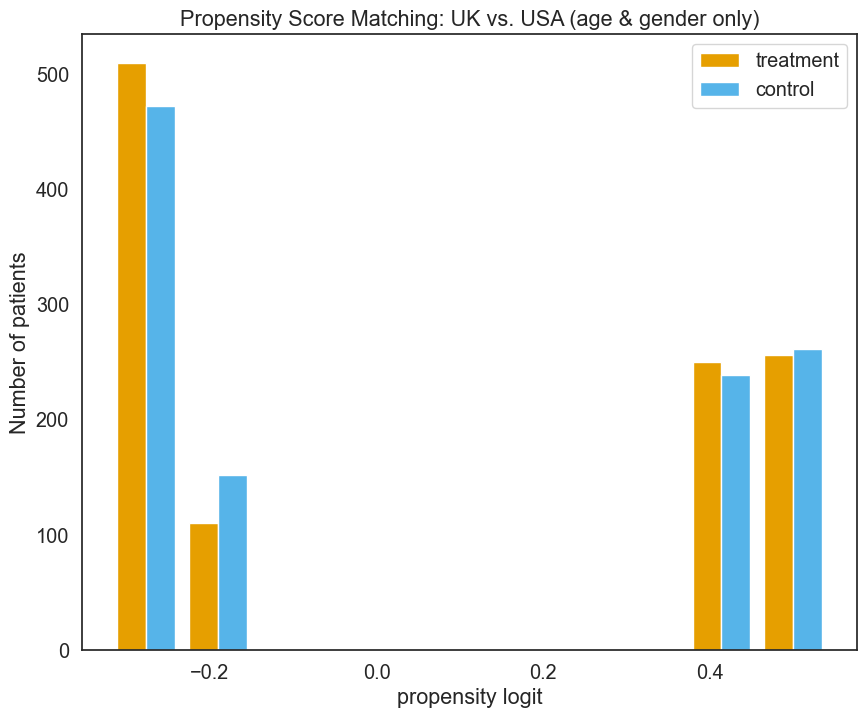

In [9]:
from psmpy import PsmPy
from psmpy.functions import cohenD

# Encode gender
df_filtered["gender"] = df_filtered["gender"].str.lower().str.strip()
df_filtered["gender_encoded"] = df_filtered["gender"].map({"male": 0, "female": 1})

# Create df for PSM
psm_df = df_filtered[["user", "country", "age", "gender_encoded"]].copy()

# Define treatment variable (USA = 1, UK = 0)
psm_df["treatment"] = psm_df["country"].apply(lambda x: 1 if x == "United States" else 0)

# Initialize PSM model
psm = PsmPy(psm_df,
            treatment='treatment',
            indx='user',
            exclude=['country'])  # exclude non-covariates

# Estimate propensity scores via logistic regression
psm.logistic_ps(balance=True)

# Nearest neighbor matching 1:1
psm.knn_matched(matcher='propensity_logit', replacement=False)

# Plot balance check (optional)
psm.plot_match(Title='Propensity Score Matching: UK vs. USA (age & gender only)')

# Merge matched users with original df to get country info
# matched_df = psm.df_matched.merge(df_filtered[["user", "country"]], left_index=True, right_on="user")
matched_df = psm.df_matched.reset_index().merge(
    df_filtered[["user", "country"]], on="user"
)

# Get matched samples
# matched_df = psm.df_matched
uk_matched = matched_df[matched_df["country"] == "United Kingdom"]
us_matched = matched_df[matched_df["country"] == "United States"]

print(f"Matched UK users: {len(uk_matched)}")
print(f"Matched US users: {len(us_matched)}")

# Extract IDs of matches users
uk_user_ids = uk_matched["user"].tolist()
us_user_ids = us_matched["user"].tolist()

matched_ids = {
    "UK": uk_user_ids,
    "US": us_user_ids
}

# Save to JSON file
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(matched_ids, f, indent=2)

##### Bipartite Network & Projection

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
matched_user_ids = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics","country", "UK - US", "pms_matched_user_ids.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "country", "UK - US")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Load file with matched user ids (w. PMS)
with open(matched_user_ids, "r", encoding="utf-8") as f:
    matched_users_data = json.load(f)

# Combine PMS-matched users for UK and USA
pms_matched_users = set(matched_users_data.get("UK", []) + matched_users_data.get("US", []))

# Define countries of a subgroup
target_countries = ["United Kingdom", "United States"]

# 1. Create an edge list (user, cluster, weight)
# user - source node
# cluster - target node
# weight - for frequency of co-occurrence
# and split by country
edge_counts = {country: defaultdict(int) for country in target_countries}
users_with_tags = {country: set() for country in target_countries}

for user, info in data.items():
    if user not in pms_matched_users:
        continue
        
    clusters = info.get("tag_clusters", [])
        
    country = info.get("demographics", {}).get("country")

    if country not in target_countries:
        continue
    
    for cluster in clusters:
        if cluster != "N/A":
            edge_counts[country][(user, cluster)] += 1
            users_with_tags[country].add(user)

def build_and_project_graph(country):
    # 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
    # Input: nodes (source & target) & edge list
    B = nx.Graph()
    
    # Add nodes (Users & Clusters)
    users = set()
    clusters = set()
    
    for (user, cluster), weight in edge_counts[country].items():
        users.add(user)
        clusters.add(cluster)
        B.add_node(user, bipartite=0)  # users
        B.add_node(cluster, bipartite=1)  # clusters
        B.add_edge(user, cluster, weight=weight)
    
    # Show edge list
    edge_list = [(u, c, w) for (u, c), w in edge_counts[country].items()]
    df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight"])
    print(df.head(5))
    
    # 3. Project to cluster-cluster co-occurrence network
    projected = nx.bipartite.weighted_projected_graph(B, clusters)
    
    # 4. Save the projected network edge list (cluster co-occurrence)
    cooccurrence_edges = [
        {"source": u, "target": v, "weight": d["weight"]}
        for u, v, d in projected.edges(data=True)
    ]

    file_name = os.path.join(output_path, f"cluster_co-occurrence_{country}.json")
    
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(cooccurrence_edges, f, indent=2)
    
    print(f"\nProjected cluster co-occurrence edges saved to: {file_name}")
    
    print(f"\nSummary for {country} - users:")
    # print(f"Total users in file: {len(data)}")
    print(f"Users with at least one cluster: {len(users_with_tags[country])}")
    print(f"Total user-cluster edges: {len(edge_counts[country])}")
    print(f"Unique clusters: {len(clusters)}")
    print(f"Edges in projected cluster-cluster graph: {projected.number_of_edges()}")

    return df

# Run for each country
df_uk = build_and_project_graph("United Kingdom")
df_us = build_and_project_graph("United States")

#### **3. US | Canada (w/ matching)**

##### Propensity Matching Score (PMS)

In [11]:
import os
import json
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "country", "US - Canada", "pms_matched_user_ids.json")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract relevant user info (age, gender) into rows (one row for each user)
rows = []
for user, info in data.items():
    demographics = info.get("demographics", {})
    
    country = demographics.get("country", "N/A")
    age = demographics.get("age", "N/A")
    gender = demographics.get("gender", "N/A")

    # Save row for this user
    rows.append({
        "user": user,
        "country": country,
        "age": age,
        "gender": gender
    })

df = pd.DataFrame(rows)

countries = ["United States", "Canada"]

# Filter based on countries of interest
df_filtered = df[df["country"].isin(countries)].copy()

# Remove rows with no age and gender
df_filtered = df_filtered[~df_filtered["age"].isin(["N/A"])]
df_filtered = df_filtered[~df_filtered["gender"].isin(["N/A", "Others"])]

# Convert age to numeric type
df_filtered["age"] = pd.to_numeric(df_filtered["age"], errors="coerce")

# Remove rows where age could not be converted
df_filtered = df_filtered.dropna(subset=["age"])

print(f"USA: {df_filtered[df_filtered['country'] == 'United States'].shape[0]}")
print(f"UK: {df_filtered[df_filtered['country'] == 'Canada'].shape[0]}")

df_filtered.head(5)
print("\n", df_filtered["gender"].value_counts())
# print("\n", df_filtered["age"].value_counts())

USA: 1125
UK: 104

 gender
Female    677
Male      552
Name: count, dtype: int64


Matched US users: 104
Matched Canada users: 104


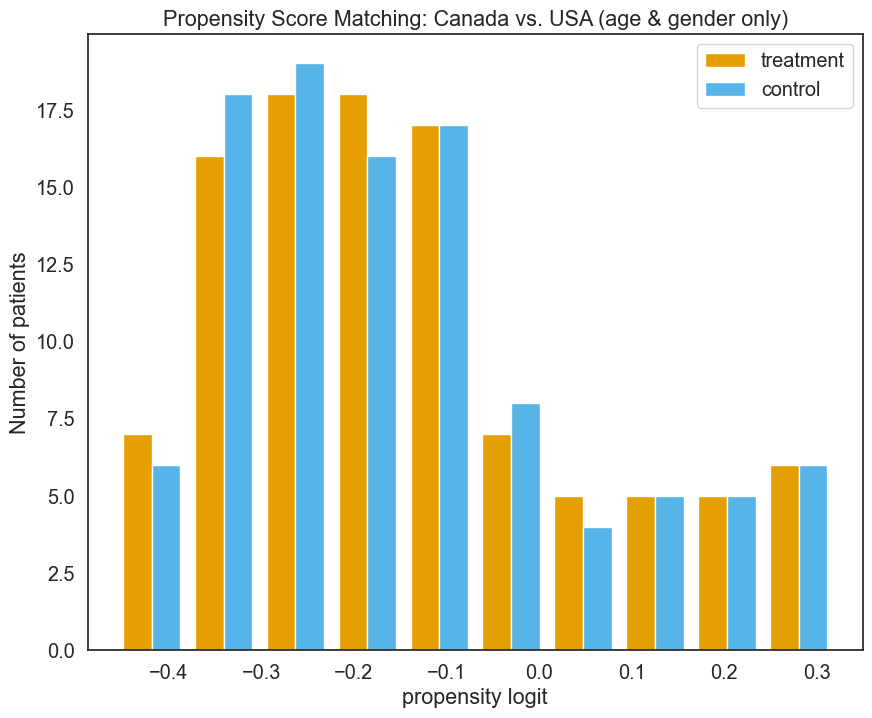

In [12]:
from psmpy import PsmPy
from psmpy.functions import cohenD

# Encode gender
df_filtered["gender"] = df_filtered["gender"].str.lower().str.strip()
df_filtered["gender_encoded"] = df_filtered["gender"].map({"male": 0, "female": 1})

# Create df for PSM
psm_df = df_filtered[["user", "country", "age", "gender_encoded"]].copy()

# Define treatment variable (USA = 1, Canada = 0)
psm_df["treatment"] = psm_df["country"].apply(lambda x: 1 if x == "United States" else 0)

# Initialize PSM model
psm = PsmPy(psm_df,
            treatment='treatment',
            indx='user',
            exclude=['country'])  # exclude non-covariates

# Estimate propensity scores via logistic regression
psm.logistic_ps(balance=True)

# Nearest neighbor matching 1:1
psm.knn_matched(matcher='propensity_logit', replacement=False)

# Plot balance check (optional)
psm.plot_match(Title='Propensity Score Matching: Canada vs. USA (age & gender only)')

# Merge matched users with original df to get country info
# matched_df = psm.df_matched.merge(df_filtered[["user", "country"]], left_index=True, right_on="user")
matched_df = psm.df_matched.reset_index().merge(
    df_filtered[["user", "country"]], on="user"
)

# Get matched samples
# matched_df = psm.df_matched
us_matched = matched_df[matched_df["country"] == "United States"]
canada_matched = matched_df[matched_df["country"] == "Canada"]

print(f"Matched US users: {len(us_matched)}")
print(f"Matched Canada users: {len(canada_matched)}")

# Extract IDs of matches users
us_user_ids = us_matched["user"].tolist()
canada_user_ids = canada_matched["user"].tolist()

matched_ids = {
    "US": us_user_ids,
    "Canada": canada_user_ids,
}

# Save to JSON file
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(matched_ids, f, indent=2)

##### Bipartite Network & Projection

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
matched_user_ids = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics","country", "US - Canada", "pms_matched_user_ids.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "country", "US - Canada")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Load file with matched user ids (w. PMS)
with open(matched_user_ids, "r", encoding="utf-8") as f:
    matched_users_data = json.load(f)

# Combine PMS-matched users for US and Canada
pms_matched_users = set(matched_users_data.get("US", []) + matched_users_data.get("Canada", []))

# Define countries of a subgroup
target_countries = ["United States", "Canada"]

# 1. Create an edge list (user, cluster, weight)
# user - source node
# cluster - target node
# weight - for frequency of co-occurrence
# and split by country
edge_counts = {country: defaultdict(int) for country in target_countries}
users_with_tags = {country: set() for country in target_countries}

for user, info in data.items():
    if user not in pms_matched_users:
        continue
        
    clusters = info.get("tag_clusters", [])
        
    country = info.get("demographics", {}).get("country")

    if country not in target_countries:
        continue
    
    for cluster in clusters:
        if cluster != "N/A":
            edge_counts[country][(user, cluster)] += 1
            users_with_tags[country].add(user)

def build_and_project_graph(country):
    # 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
    # Input: nodes (source & target) & edge list
    B = nx.Graph()
    
    # Add nodes (Users & Clusters)
    users = set()
    clusters = set()
    
    for (user, cluster), weight in edge_counts[country].items():
        users.add(user)
        clusters.add(cluster)
        B.add_node(user, bipartite=0)  # users
        B.add_node(cluster, bipartite=1)  # clusters
        B.add_edge(user, cluster, weight=weight)
    
    # Show edge list
    edge_list = [(u, c, w) for (u, c), w in edge_counts[country].items()]
    df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight"])
    print(df.head(5))
    
    # 3. Project to cluster-cluster co-occurrence network
    projected = nx.bipartite.weighted_projected_graph(B, clusters)
    
    # 4. Save the projected network edge list (cluster co-occurrence)
    cooccurrence_edges = [
        {"source": u, "target": v, "weight": d["weight"]}
        for u, v, d in projected.edges(data=True)
    ]

    file_name = os.path.join(output_path, f"cluster_co-occurrence_{country}.json")
    
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(cooccurrence_edges, f, indent=2)
    
    print(f"\nProjected cluster co-occurrence edges saved to: {file_name}")
    
    print(f"\nSummary for {country} - users:")
    # print(f"Total users in file: {len(data)}")
    print(f"Users with at least one cluster: {len(users_with_tags[country])}")
    print(f"Total user-cluster edges: {len(edge_counts[country])}")
    print(f"Unique clusters: {len(clusters)}")
    print(f"Edges in projected cluster-cluster graph: {projected.number_of_edges()}")

    return df

# Run for each country
df_us = build_and_project_graph("United States")
df_canada = build_and_project_graph("Canada")

#### **4.UK | Ireland (w/ matching)**

##### Propensity Matching Score (PMS)

In [21]:
import os
import json
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "country", "UK - Ireland", "pms_matched_user_ids.json")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract relevant user info (age, gender) into rows (one row for each user)
rows = []
for user, info in data.items():
    demographics = info.get("demographics", {})
    
    country = demographics.get("country", "N/A")
    age = demographics.get("age", "N/A")
    gender = demographics.get("gender", "N/A")

    # Save row for this user
    rows.append({
        "user": user,
        "country": country,
        "age": age,
        "gender": gender
    })

df = pd.DataFrame(rows)

countries = ["United Kingdom", "Ireland"]

# Filter based on countries of interest
df_filtered = df[df["country"].isin(countries)].copy()

# Remove rows with no age and gender
df_filtered = df_filtered[~df_filtered["age"].isin(["N/A"])]
df_filtered = df_filtered[~df_filtered["gender"].isin(["N/A", "Others"])]

# Convert age to numeric type
df_filtered["age"] = pd.to_numeric(df_filtered["age"], errors="coerce")

# Remove rows where age could not be converted
df_filtered = df_filtered.dropna(subset=["age"])

print(f"UK: {df_filtered[df_filtered['country'] == 'United Kingdom'].shape[0]}")
print(f"Ireland: {df_filtered[df_filtered['country'] == 'Ireland'].shape[0]}")

df_filtered.head(5)
print("\n", df_filtered["gender"].value_counts())
# print("\n", df_filtered["age"].value_counts())

UK: 1821
Ireland: 33

 gender
Female    1344
Male       510
Name: count, dtype: int64


Matched UK users: 33
Matched Ireland users: 33


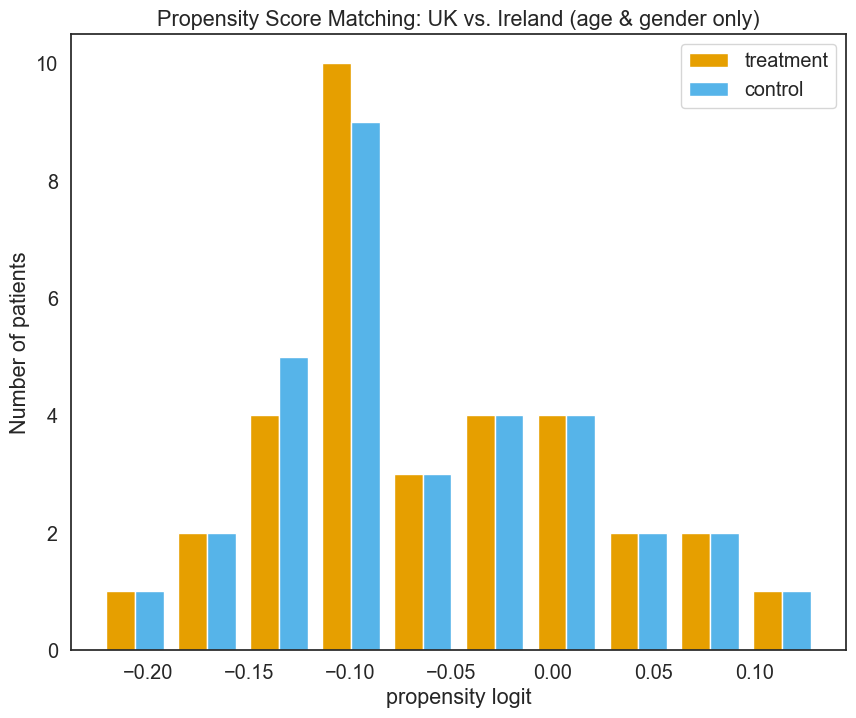

In [22]:
from psmpy import PsmPy
from psmpy.functions import cohenD

# Encode gender
df_filtered["gender"] = df_filtered["gender"].str.lower().str.strip()
df_filtered["gender_encoded"] = df_filtered["gender"].map({"male": 0, "female": 1})

# Create df for PSM
psm_df = df_filtered[["user", "country", "age", "gender_encoded"]].copy()

# Define treatment variable (UK = 1, Ireland = 0)
psm_df["treatment"] = psm_df["country"].apply(lambda x: 1 if x == "United Kingdom" else 0)

# Initialize PSM model
psm = PsmPy(psm_df,
            treatment='treatment',
            indx='user',
            exclude=['country'])  # exclude non-covariates

# Estimate propensity scores via logistic regression
psm.logistic_ps(balance=True)

# Nearest neighbor matching 1:1
psm.knn_matched(matcher='propensity_logit', replacement=False)

# Plot balance check (optional)
psm.plot_match(Title='Propensity Score Matching: UK vs. Ireland (age & gender only)')

# Merge matched users with original df to get country info
# matched_df = psm.df_matched.merge(df_filtered[["user", "country"]], left_index=True, right_on="user")
matched_df = psm.df_matched.reset_index().merge(
    df_filtered[["user", "country"]], on="user"
)

# Get matched samples
# matched_df = psm.df_matched
uk_matched = matched_df[matched_df["country"] == "United Kingdom"]
ir_matched = matched_df[matched_df["country"] == "Ireland"]

print(f"Matched UK users: {len(uk_matched)}")
print(f"Matched Ireland users: {len(ir_matched)}")

# Extract IDs of matches users
uk_user_ids = uk_matched["user"].tolist()
ir_user_ids = ir_matched["user"].tolist()

matched_ids = {
    "UK": uk_user_ids,
    "Ireland": ir_user_ids
}

# Save to JSON file
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(matched_ids, f, indent=2)

##### Bipartite Network & Projection

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
matched_user_ids = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics","country", "UK - Ireland", "pms_matched_user_ids.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "country", "UK - Ireland")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Load file with matched user ids (w. PMS)
with open(matched_user_ids, "r", encoding="utf-8") as f:
    matched_users_data = json.load(f)

# Combine PMS-matched users for UK and Ireland
pms_matched_users = set(matched_users_data.get("UK", []) + matched_users_data.get("Ireland", []))

# Define countries of a subgroup
target_countries = ["United Kingdom", "Ireland"]

# 1. Create an edge list (user, cluster, weight)
# user - source node
# cluster - target node
# weight - for frequency of co-occurrence
# and split by country
edge_counts = {country: defaultdict(int) for country in target_countries}
users_with_tags = {country: set() for country in target_countries}

for user, info in data.items():
    if user not in pms_matched_users:
        continue
        
    clusters = info.get("tag_clusters", [])
        
    country = info.get("demographics", {}).get("country")

    if country not in target_countries:
        continue
    
    for cluster in clusters:
        if cluster != "N/A":
            edge_counts[country][(user, cluster)] += 1
            users_with_tags[country].add(user)

def build_and_project_graph(country):
    # 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
    # Input: nodes (source & target) & edge list
    B = nx.Graph()
    
    # Add nodes (Users & Clusters)
    users = set()
    clusters = set()
    
    for (user, cluster), weight in edge_counts[country].items():
        users.add(user)
        clusters.add(cluster)
        B.add_node(user, bipartite=0)  # users
        B.add_node(cluster, bipartite=1)  # clusters
        B.add_edge(user, cluster, weight=weight)
    
    # Show edge list
    edge_list = [(u, c, w) for (u, c), w in edge_counts[country].items()]
    df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight"])
    print(df.head(5))
    
    # 3. Project to cluster-cluster co-occurrence network
    projected = nx.bipartite.weighted_projected_graph(B, clusters)
    
    # 4. Save the projected network edge list (cluster co-occurrence)
    cooccurrence_edges = [
        {"source": u, "target": v, "weight": d["weight"]}
        for u, v, d in projected.edges(data=True)
    ]

    file_name = os.path.join(output_path, f"cluster_co-occurrence_{country}.json")
    
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(cooccurrence_edges, f, indent=2)
    
    print(f"\nProjected cluster co-occurrence edges saved to: {file_name}")
    
    print(f"\nSummary for {country} - users:")
    # print(f"Total users in file: {len(data)}")
    print(f"Users with at least one cluster: {len(users_with_tags[country])}")
    print(f"Total user-cluster edges: {len(edge_counts[country])}")
    print(f"Unique clusters: {len(clusters)}")
    print(f"Edges in projected cluster-cluster graph: {projected.number_of_edges()}")

    return df

# Run for each country
df_us = build_and_project_graph("United Kingdom")
df_canada = build_and_project_graph("Ireland")

### Demographics Group: Age

on whole sample for now

1. 18-30 (way less than in any group)
2. 30-50
3. 50-70
4. 70+

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "age")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Define age group of a user
def get_age_group(age):
    try:
        age = int(age)
        if age < 18:
            return None
        elif 18 <= age <= 30:
            return "18-30"
        elif 30 < age <= 50:
            return "30-50"
        elif 50 < age <= 70:
            return "50-70"
        else:
            return "70+"
    except:
        return None

age_groups = defaultdict(dict)

# Group users by age group
for user, info in data.items():
    # clusters = info.get("tag_clusters", [])
    age = info.get("demographics", {}).get("age", "N/A")    
    group = get_age_group(age)

    if group:
        age_groups[group][user] = info

def build_and_project_graph(group_name, group_data):
    # 1. Create an edge list (user, cluster, weight)
    # user - source node
    # cluster - target node
    # weight - for frequency of co-occurrence
    edge_counts = defaultdict(int)
    users_with_tags = set()

    for user, info in group_data.items():
        clusters = info.get("tag_clusters", [])
        
        for cluster in clusters:
            if cluster != "N/A":
                edge_counts[(user, cluster)] += 1
                users_with_tags.add(user)
    
    # 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
    # Input: nodes (source & target) & edge list
    B = nx.Graph()
    
    # Add nodes (Users & Clusters)
    users = set()
    clusters = set()
    
    for (user, cluster), weight in edge_counts.items():
        users.add(user)
        clusters.add(cluster)
        B.add_node(user, bipartite=0)  # users
        B.add_node(cluster, bipartite=1)  # clusters
        B.add_edge(user, cluster, weight=weight)
    
    # Visualize an edge list
    edge_list = [(u, c, w) for (u, c), w in edge_counts.items()]
    df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight"])
    print(df.head(10))
    
    # 3. Project to cluster-cluster co-occurrence network
    projected = nx.bipartite.weighted_projected_graph(B, clusters)
    
    # 4. Save the projected network edge list (cluster co-occurrence)
    cooccurrence_edges = [
        {"source": u, "target": v, "weight": d["weight"]}
        for u, v, d in projected.edges(data=True)
    ]

    file_name = os.path.join(output_path, f"cluster_co-occurrence_{group_name}.json")
    
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(cooccurrence_edges, f, indent=2)
    
    print(f"\nProjected cluster co-occurrence edges saved to: {file_name}")
    
    print(f"\nSummary for {group}- users:")
    print(f"Total users in file: {len(group_data)}")
    print(f"Users with at least one cluster: {len(users_with_tags)}")
    print(f"Total user-cluster edges: {len(edge_counts)}")
    print(f"Unique clusters: {len(clusters)}")
    print(f"Edges in projected cluster-cluster graph: {projected.number_of_edges()}")

# Run for each age group
for group, users in age_groups.items():
    build_and_project_graph(group, users)

### Demographics Group: Ethnicity

On the whole sample

#### white | asian | black | latino

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict, Counter
import pandas as pd

base_dir = os.path.abspath("..")
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "general_profiles_data_with_tag_clusters.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "ethnicity")

# Load file with profiles & tag-to-cluster mapping
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Define ethnicities of a subgroup
target_ethnicities = ["white", "asian", "black", "latino"]

# 1. Create an edge list (user, cluster, weight)
# user - source node
# cluster - target node
# weight - for frequency of co-occurrence
# and split by country
edge_counts = {ethnicity: defaultdict(int) for ethnicity in target_ethnicities}
users_with_tags = {ethnicity: set() for ethnicity in target_ethnicities}

for user, info in data.items():
    clusters = info.get("tag_clusters", [])
    ethnicity = info.get("demographics", {}).get("ethnicity").lower()

    if ethnicity not in target_ethnicities:
        continue
    
    for cluster in clusters:
        if cluster != "N/A":
            edge_counts[ethnicity][(user, cluster)] += 1
            users_with_tags[ethnicity].add(user)

def build_and_project_graph(ethnicity):
    # 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
    # Input: nodes (source & target) & edge list
    B = nx.Graph()
    
    # Add nodes (Users & Clusters)
    users = set()
    clusters = set()
    
    for (user, cluster), weight in edge_counts[ethnicity].items():
        users.add(user)
        clusters.add(cluster)
        B.add_node(user, bipartite=0)  # users
        B.add_node(cluster, bipartite=1)  # clusters
        B.add_edge(user, cluster, weight=weight)
    
    # Show edge list
    edge_list = [(u, c, w) for (u, c), w in edge_counts[ethnicity].items()]
    df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight"])
    print(df.head(5))
    
    # 3. Project to cluster-cluster co-occurrence network
    projected = nx.bipartite.weighted_projected_graph(B, clusters)
    
    # 4. Save the projected network edge list (cluster co-occurrence)
    cooccurrence_edges = [
        {"source": u, "target": v, "weight": d["weight"]}
        for u, v, d in projected.edges(data=True)
    ]

    file_name = os.path.join(output_path, f"cluster_co-occurrence_{ethnicity}.json")
    
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(cooccurrence_edges, f, indent=2)
    
    print(f"\nProjected cluster co-occurrence edges saved to: {file_name}")
    
    print(f"\nSummary for {ethnicity} - users:")
    # print(f"Total users in file: {len(data)}")
    print(f"Users with at least one cluster: {len(users_with_tags[ethnicity])}")
    print(f"Total user-cluster edges: {len(edge_counts[ethnicity])}")
    print(f"Unique clusters: {len(clusters)}")
    print(f"Edges in projected cluster-cluster graph: {projected.number_of_edges()}")

    return df

# Run for each country
df_white = build_and_project_graph("white")
df_asian = build_and_project_graph("asian")
df_black = build_and_project_graph("black")
df_latino = build_and_project_graph("latino")

## 2. Community-Specific Patterns

### Create for EACH community a separate network:
user123 | repiratory desease | 3 (weight) | +1 new col: comm_url

In [ ]:
import json
import os
import networkx as nx
from collections import defaultdict
import pandas as pd

base_dir = os.path.abspath("..")
input_path = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "profiles_by_comm_data_with_tag_clusters.json")
output_dir = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "cluster_co-occurrence_edges_by_comm")
os.makedirs(output_dir, exist_ok=True)

# Load file with profiles by community & tag-to-cluster mapping
with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# total_communities = len(data)
valid_communities = 0
skipped_communities = 0

# Create for EACH community a SEPARATE network
for comm_url, users_dict in data.items():
    print(f"\nProcessing community: {comm_url}")
    edge_counts = defaultdict(int)
    
    # # 1. Create an edge list (user, cluster, weight)
    # user - source node
    # cluster - target node
    # weight - for frequency of co-occurrence
    for user, profile in users_dict.items():
        clusters = profile.get("tag_clusters", [])
        for cluster in clusters:
            if cluster != "N/A":
                edge_counts[(user, cluster)] += 1

    # Skip community where members have not set any tags
    if not edge_counts:
        print(f"Skipping {comm_url}: no user-cluster edges.")
        skipped_communities += 1
        continue
    valid_communities += 1
    
    # 2. Create a bipartite graph (2 types of nodes: Users & Clusters)
    # Input: nodes (source & target) & edge list
    B = nx.Graph()

    # Add nodes (Users & Clusters)
    users = set()
    clusters = set()
    
    for (user, cluster), weight in edge_counts.items():
        users.add(user)
        clusters.add(cluster)
        B.add_node(user, bipartite=0)
        B.add_node(cluster, bipartite=1)
        B.add_edge(user, cluster, weight=weight)
    
    # Visualize an edge list
    edge_list = [(user, cluster, weight, comm_url) for (user, cluster), weight in edge_counts.items()]
    df = pd.DataFrame(edge_list, columns=["user", "cluster", "weight", "comm_url"])
    print(df.head(10))
    
    # 3. Project to cluster-cluster co-occurrence network
    projected = nx.bipartite.weighted_projected_graph(B, clusters)
    
    # 4. Save the projected network edge list (cluster co-occurrence)
    cooccurrence_edges = [
        {"source": u, "target": v, "weight": d["weight"]}
        for u, v, d in projected.edges(data=True)
    ]
    
    # Get filename from "comm_url" (e.g. "/pmrgcauk" -> "pmrgcauk.json")
    community_filename = comm_url.strip("/").replace("/", "_") + "_co-occurrence.json"
    output_path = os.path.join(output_dir, community_filename)

    with open(output_path, "w", encoding="utf-8") as f_out:
        json.dump(cooccurrence_edges, f_out, indent=2)

    print(f"\nProjected cluster co-occurrence edges saved to: {output_path}")
    
print("\nSummary:")
print(f"Total communities: {len(data)}")
print(f"Communities with tags: {valid_communities}")
print(f"Communities skipped (no tags): {skipped_communities}")